# How to detect branches in clusters

HDBSCAN\* is often used to find subpopulations in exploratory data analysis
workflows. Not only clusters themselves, but also their shape can represent
meaningful subpopulations. For example, a Y-shaped cluster may represent an
evolving process with two distinct end-states. Detecting these branches can
reveal interesting patterns that are not captured by density-based clustering.

For example, HDBSCAN\* finds 4 clusters in the datasets below, which does not
inform us of the branching structure:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hdbscan import HDBSCAN, BranchDetector

In [16]:
def plot(labels):
    """Plots the data coloured by labels, with noise points in silver."""
    noise_mask = labels == -1
    plt.scatter(data[noise_mask, 0], data[noise_mask, 1], 1, color="silver")
    plt.scatter(
        data[~noise_mask, 0],
        data[~noise_mask, 1],
        1,
        labels[~noise_mask] % 10,
        cmap="tab10",
        vmin=0,
        vmax=9,
    )
    plt.axis("off")
    plt.show()

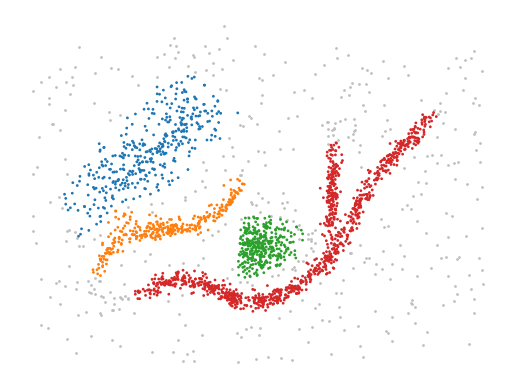

In [24]:
# Control points for line segments that merge three clusters
p0 = (0.13, -0.26)
p1 = (0.24, -0.12)
p2 = (0.32, 0.1)

# Noisy points along lines between three clusters
segments = [
    np.column_stack(
        (np.linspace(p_start[0], p_end[0], 100), np.linspace(p_start[1], p_end[1], 100))
    )
    + np.random.normal(size=(100, 2), scale=0.01)
    for p_start, p_end in [(p0, p1), (p1, p2)]
]

# Original data with new segments
data = np.load("./clusterable_data.npy")
data = np.concatenate((data, *segments))

# HDBSCAN clusters
clusterer = HDBSCAN(min_cluster_size=15).fit(data)
plot(clusterer.labels_)

Alternatively, HDBSCAN\*'s leaf clusters provide more detail. They segment the
points of different branches into distinct clusters. However, the partitioning
and cluster hierarchy does not (necessarily) tell us how those clusters combine
into a larger shape.

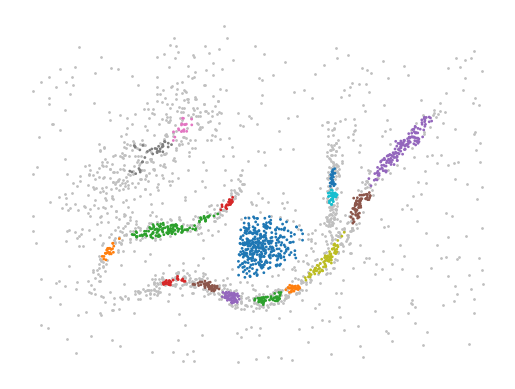

In [25]:
leaf_clusterer = HDBSCAN(min_cluster_size=15, cluster_selection_method='leaf').fit(data)
plot(leaf_clusterer.labels_)

This is where the branch detection post-processing step comes into play. The
functionality is described in detail by [Bot et
al](https://arxiv.org/abs/2311.15887) (please reference this paper when using
this functionality). It operates on the detected clusters and extracts a
branch-hierarchy analogous to HDBSCAN\*'s condensed cluster hierarchy. The
process is very similar to HDBSCAN\* clustering, except that it operates on an
in-cluster eccentricity rather than a density measure. Where peaks in a density
profile correspond to clusters, the peaks in an eccentricity profile correspond
to branches:

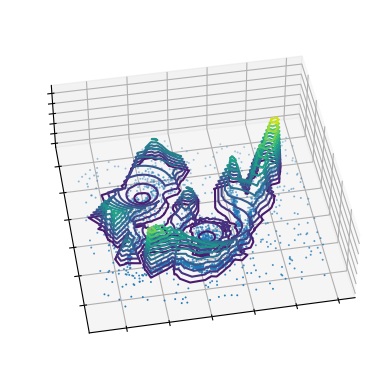

In [47]:
import matplotlib.tri as mtri

eccentricities = np.zeros(data.shape[0])
for label in range(len(clusterer.cluster_persistence_)):
    mask = clusterer.labels_ == label
    centroid = np.average(
        data[mask],
        weights=clusterer.probabilities_[mask],
        axis=0,
    )
    eccentricities[mask] = np.linalg.norm(data[mask] - centroid, axis=1)

fig = plt.figure()
tri = mtri.Triangulation(data[:, 0], data[:, 1])
ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=45, azim=-100)
ax.scatter(
    data.T[0],
    data.T[1],
    np.repeat(eccentricities.min(), data.shape[0]),
    s=2,
    edgecolor="none",
    linewidth=0,
)
ax.tricontour(tri, eccentricities, levels=np.linspace(0, eccentricities.max(), 15))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
zlim = ax.get_zlim()
ax.set_box_aspect(aspect=(3, 3, 1))

Using the branch detection functionality is fairly straightforward. First, run
hdbscan with parameter `branch_detection_data=True`. This tells hdbscan to cache
the internal data structures needed for the branch detection process. Then,
configure the ``BranchDetector`` class and fit is with the HDBSCAN object.

The resulting partitioning reflects subgroups for clusters and their
branches:

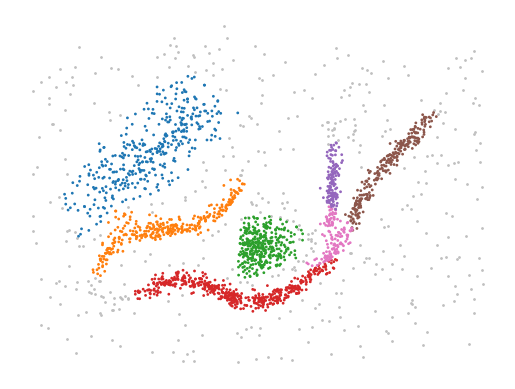

In [48]:
clusterer = HDBSCAN(min_cluster_size=15, branch_detection_data=True).fit(data)
branch_detector = BranchDetector(min_branch_size=15).fit(clusterer)
plot(branch_detector.labels_)

## Parameter selection

The `BranchDetector`'s main parameters are very similar to HDBSCAN\*. Most
guidelines for tuning HDBSCAN\* also apply for the branch detector:

- `min_branch_size` behaves like HDBSCAN\*'s `min_cluster_size`. It configures
  how many points branches need to contain. Values around 10 to 25 points tend
  to work well. Lower values are useful when looking for smaller structures.
  Higher values can be used to suppress noise if present.
- `branch_selection_method` behaves like HDBSCAN\*'s `cluster_selection_method`.
  The leaf and Excess of Mass (EOM) strategies are used to select branches from
  the condensed hierarchies. By default, branches are only reflected in the
  final labelling for clusters that have 3 or more branches (at least one
  bifurcation).
- `branch_selection_persistence` replaces HDBSCAN\*'s `cluster_selection_epsilon`.
  This parameter can be used to suppress branches with a short eccentricity
  range (y-range in the condensed hierarchy plot).
- `allow_single_branch` behaves like HDBSCAN\*'s `allow_single_cluster` and
  mostly affects the EOM selection strategy. When enabled, clusters with
  bifurcations will be given a single label if the root segment contains most
  eccentricity mass (i.e., branches already merge far from the center and most
  points are central).
- `max_branch_size` behaves like HDBSCAN\*'s `max_cluster_size` and mostly
  affects the EOM selection strategy. Branches with more than the specified
  number of points are skipped, selecting their descendants in the hierarchy
  instead.

Two parameters are unique to the `BranchDetector` class:

- `branch_detection_method` determines which points are connected within a
  cluster. Both density-based clustering and the branch detection process need
  to determine which points are part of the same density/eccentricity peak.
  HDBSCAN\* defines density in terms of the distance between points, providing
  natural way to define which points are connected at some density value.
  Eccentricity does not have such a connection. So, we use information from the
  clusters to determine which points should be connected instead.
  - The `"core"` method selects all edges that could be part of the cluster's
    minimum spanning tree under HDBSCAN\*'s mutual reachability distance. This
    graph contains the detected MST and all `min_samples`-nearest neighbours. 
  - The `"full"` method connects all points with a mutual reachability lower
    than the maximum distance in the cluster's MST. It represents all connectivity
    at the moment the last point joins the cluster. These methods differ in
  their sensitivity, noise robustness, and computational cost. The `"core"`
  method usually needs slightly higher `min_branch_size` values to suppress
  noisy branches than the `"full"` method. It is a good choice when branches
  span large density ranges.
- `label_sides_as_branches` determines whether the sides of an elongated cluster
  without bifurcations (l-shape) are represented as distinct subgroups. By
  default a cluster needs to have one bifurcation (Y-shape) before the detected
  branches are represented in the final labelling.

## Useful attributes

Like the HDBSCAN class, the BranchDetector class contains several useful
attributes for exploring datasets.

### Branch hierarchy

Branch hierarchies reflect the tree-shape of clusters. Like the cluster
hierarchy, branch hierarchies can be used to interpret which branches exist. In
addition, they reflect how far apart branches merge into the cluster. 

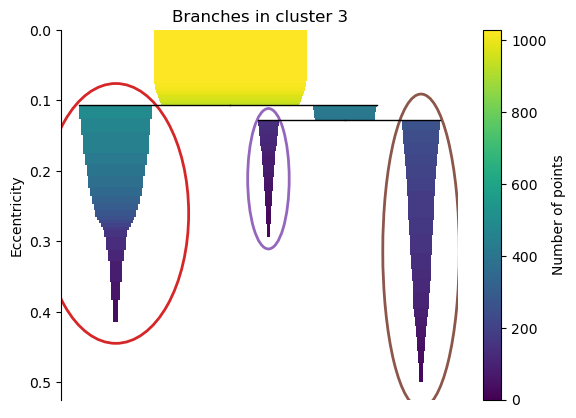

In [51]:
idx = np.argmax([len(x) for x in branch_detector.branch_persistences_])
branch_detector.cluster_condensed_trees_[idx].plot(
    select_clusters=True, selection_palette=["C3", "C4", "C5"]
)
plt.ylabel("Eccentricity")
plt.title(f"Branches in cluster {idx}")
plt.show()

The length of the branches also says something about the compactness /
elongatedness of clusters. For example, the branch hierarchy for the orange
~-shaped cluster is quite different from the same hierarchy for the central
o-shaped cluster.

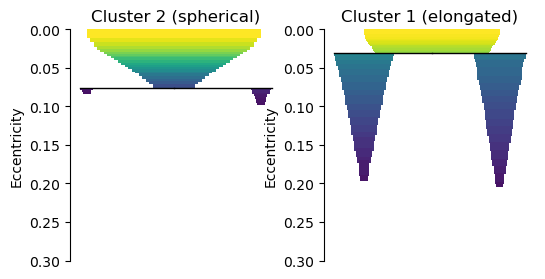

In [52]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
idx = np.argmin([min(*x) for x in branch_detector.branch_persistences_])
branch_detector.cluster_condensed_trees_[idx].plot(colorbar=False)
plt.ylim([0.3, 0])
plt.ylabel("Eccentricity")
plt.title(f"Cluster {idx} (spherical)")

plt.subplot(1, 2, 2)
idx = np.argmax([max(*x) for x in branch_detector.branch_persistences_])
branch_detector.cluster_condensed_trees_[idx].plot(colorbar=False)
plt.ylim([0.3, 0])
plt.ylabel("Eccentricity")
plt.title(f"Cluster {idx} (elongated)")
plt.show()

### Cluster approximation graphs

Branches are detected using a graph that approximates the connectivity within a
cluster. These graphs are available in the `cluster_approximation_graph_`
property and can be used to visualise data and the branch-detection process. The
plotting function is based on the networkx API and uses networkx functionality
to compute a layout if positions are not provided. Using UMAP to compute
positions can be faster and more expressive. Several helper functions for
exporting to numpy, pandas, and networkx are available.

For example, a figure with points coloured by the final labelling:

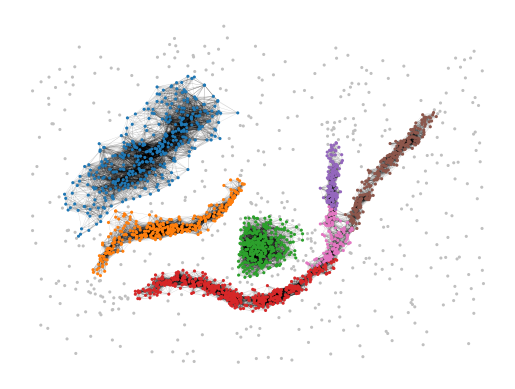

In [53]:
g = branch_detector.cluster_approximation_graph_
g.plot(positions=data, node_size=5, edge_width=0.2, edge_alpha=0.2)
plt.show()

Or, a figure with the edges coloured by centrality:

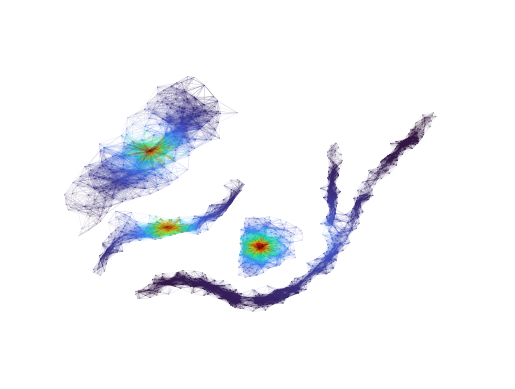

In [54]:
g.plot(
    positions=data,
    node_alpha=0,
    edge_color="centrality",
    edge_cmap="turbo",
    edge_width=0.2,
    edge_alpha=0.2,
    edge_vmax=100,
)
plt.show()

## Approximate predict

A branch-aware ``approximate_predict_branch`` function is available to predicts
branch labels for new points. This function uses a fitted BranchDetector object
to first predict cluster labels and then the branch labels.

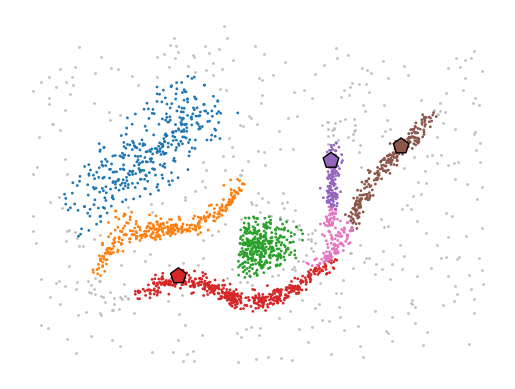

In [55]:
from hdbscan import approximate_predict_branch

new_points = np.asarray([[0.4, 0.25], [0.23, 0.2], [-0.14, -0.2]])
clusterer.generate_prediction_data()
labels, probs, cluster_labels, cluster_probs, branch_labels, branch_probs = (
    approximate_predict_branch(branch_detector, new_points)
)

plt.scatter(
    new_points.T[0],
    new_points.T[1],
    140,
    labels % 10,
    marker="p",
    zorder=5,
    cmap="tab10",
    vmin=0,
    vmax=9,
    edgecolor="k",
)
plot(branch_detector.labels_)
plt.show()